In [1]:
# Import Libraries

%matplotlib inline
import sys
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import time
import matplotlib.dates as mdates
import email
import getpass, imaplib
import os
import sys
import base64
from io import BytesIO

import requests 
requests.packages.urllib3.disable_warnings()
#Requests enables us to download raw html as text
from bs4 import BeautifulSoup 
# BeautifulSoup enables us to navigate html in python with dom-like tree structure 

In [2]:
# Define Scraping Functions

# Define Functions

# Dictionary to store already downloaded BeautifulSoup objects 
html_cache = dict()

# Define functions to use BeautifulSoup
def dl_parsed_html(url, timeout=20, verify=False, sleep_time=1):
    """Downloads the content of the page specified by url.
    Return the parsed HTML or None upon error.
    Notice that timeout, verify, and sleep_time have 
    defaults values"""
    
    # Down load the context at url
    r = requests.get(url, timeout=20,verify=False)
    
    # Check if HTTP status code is anything other than "ok"
    if r.status_code != 200:
        return None
    
    # Grab the raw HTML of the result
    raw_html = r.text
    
    # Parse the raw HTML with Beautiful soup
    soup = BeautifulSoup(raw_html, 'html.parser')
    
    # We have added a default 1 sec sleep
    time.sleep(sleep_time)
    
    # Return the parsed results
    return soup

def get_parsed_html(url, timeout=20, verify=False, sleep_time=1):
    """If we’ve already downloaded a webpage, return from cache. 
    Otherwise, download and parse using dl_parsed_html above."""
    if url not in html_cache:
        parsed_html = dl_parsed_html(url, timeout, verify, sleep_time)
        if parsed_html:
            html_cache[url] = parsed_html 
            
    return html_cache.get(url,None)

_______________________________________________________________________________________________________________________________

## TSA Daily Flights

In [3]:
#Scrape

url = "https://www.tsa.gov/coronavirus/passenger-throughput"

soup = get_parsed_html(url)

table = soup.find_all("table")

dct = {}

for el in table[0].find_all('tr')[0].find_all('td'):
    txt = el.text
    dct[txt] = []


keys = list(dct.keys())
    
for el in table[0].find_all('tr')[1:]:
    
    x = 0
    
    for el1 in el.find_all('td'):
                
        dct[keys[x]].append(el1.text)
        
        x = x+1

tsa_df = pd.DataFrame(dct)

date = tsa_df.iloc[0, 0]
new_string = date.split('/')[0]
for el in date.split('/')[1:]:
    new_string = new_string + '-' + el

title = 'TSA Data as of ' + new_string + '.csv'

def safe_date(x):
    return pd.to_datetime(x, format='%m/%d/%Y')

tsa_df['Day'] = tsa_df[list(tsa_df.columns)[0]].apply(safe_date)
tsa_df = tsa_df.sort_values(by = 'Day', ascending = True)

import locale
locale.setlocale( locale.LC_ALL, 'en_US.UTF-8' ) 

tsa_df['Total Traveler Throughput'] = tsa_df['Total Traveler Throughput'].apply(locale.atoi)

tsa_df['Total Traveler Throughput\n\t\t\t(1 Year Ago - Same Weekday)'] = tsa_df['Total Traveler Throughput\n\t\t\t(1 Year Ago - Same Weekday)'].apply(locale.atoi)


tsa_df.to_csv(title)

tsa_df.head()

,Date,Total Traveler Throughput,Total Traveler Throughput (1 Year Ago - Same Weekday),Day
77,3/1/2020,2280522,2301439,2020-03-01
76,3/2/2020,2089641,2257920,2020-03-02
75,3/3/2020,1736393,1979558,2020-03-03
74,3/4/2020,1877401,2143619,2020-03-04
73,3/5/2020,2130015,2402692,2020-03-05


C:\Users\mark\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


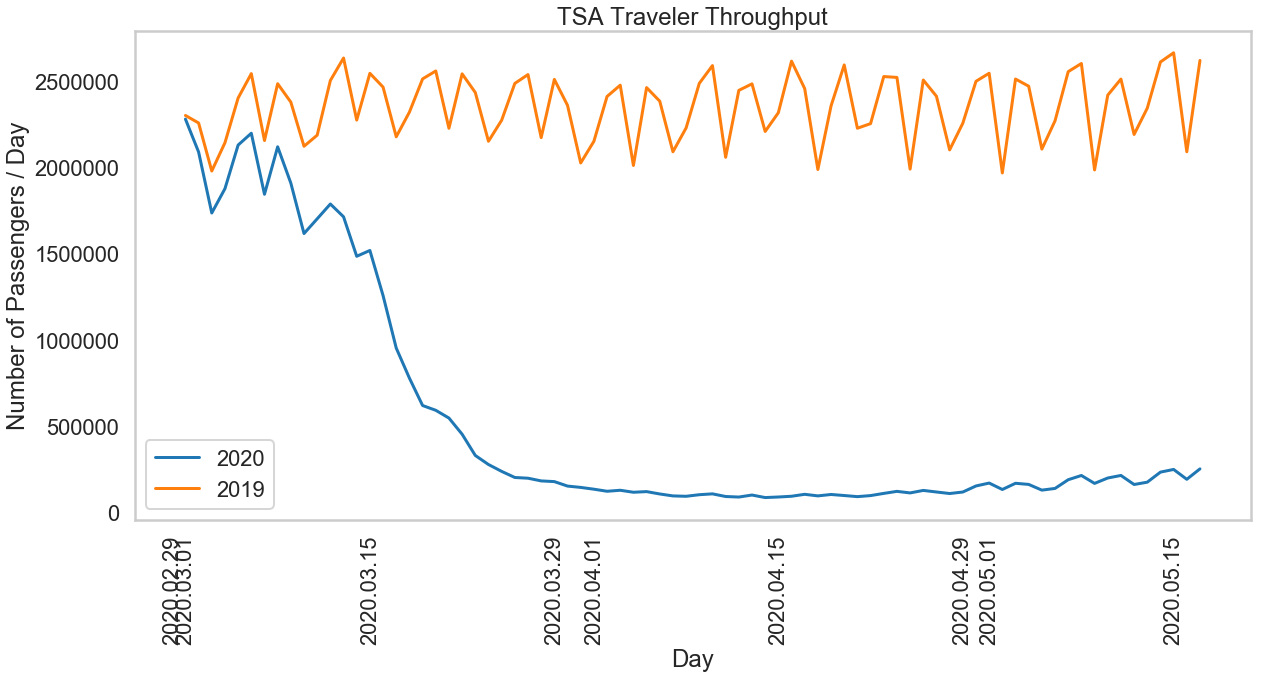

In [4]:
# Plot

fig = plt.figure(figsize=(20,9))
x = sns.lineplot(data=tsa_df, x='Day', y='Total Traveler Throughput', label="2020")
y = sns.lineplot(data=tsa_df, x='Day', y='Total Traveler Throughput\n\t\t\t(1 Year Ago - Same Weekday)', label="2019")
x.set_title('TSA Traveler Throughput')
x.set_xlabel('Day')
x.set_ylabel('Number of Passengers / Day')
x.grid(False)
x.xaxis.set_major_locator(mdates.AutoDateLocator())
x.xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m.%d'))
plt.setp(x.get_xticklabels(), rotation=90)
x.legend()

_______________________________________________________________________________________________________________________________